In [57]:
!pip install mnist


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [70]:
train, validation, test = load_mnist()
X_train, y_train = train
X_test, y_test = test


Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [72]:
print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)


Train data shape: (55000, 28, 28, 1)
Train labels shape: (55000,)
Test data shape: (10000, 28, 28, 1)
Test labels shape: (10000,)


## Шаг I: Визуализация датасета

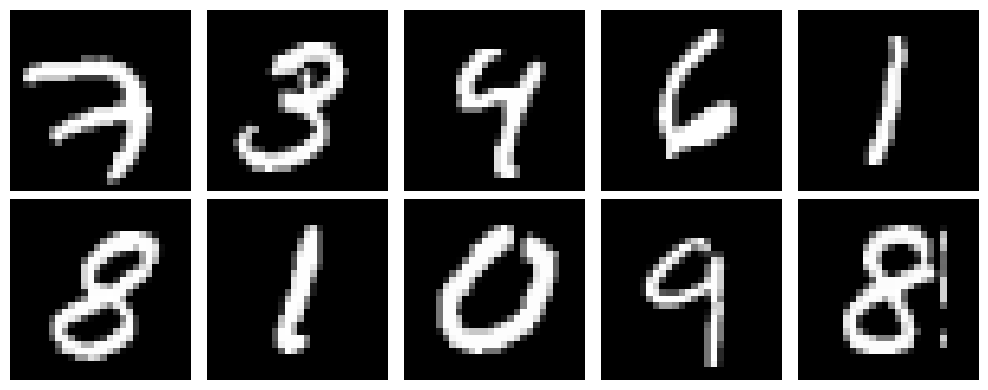

In [73]:
# Нарисуем несколько примеров картинок из X_train
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## Шаг II: Алгоритм PCA

In [77]:
class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean = None
        self.eigenvectors = None
        self.eigenvalues = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        centered_X = X - self.mean
        cov_matrix = np.cov(centered_X, rowvar=False)
        self.eigenvalues, self.eigenvectors = np.linalg.eig(cov_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = self.eigenvectors[:, idx]

    def transform(self, X):
        centered_X = X - self.mean
        if self.n_components is not None:
            reduced_eigenvectors = self.eigenvectors[:, :self.n_components]
            return np.dot(centered_X, reduced_eigenvectors)
        else:
            return np.dot(centered_X, self.eigenvectors)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


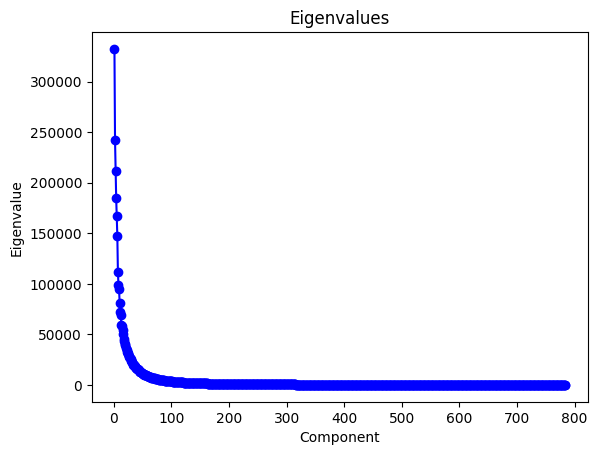

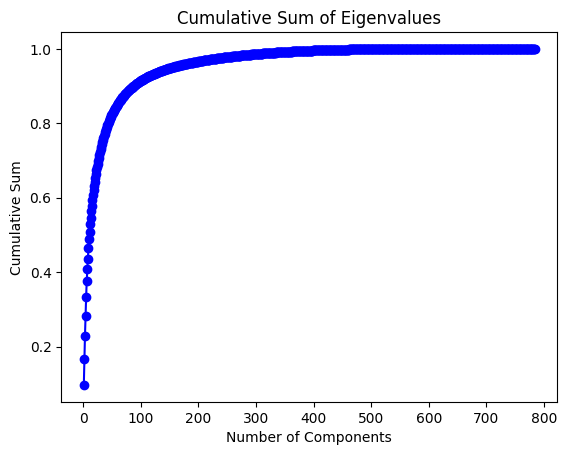

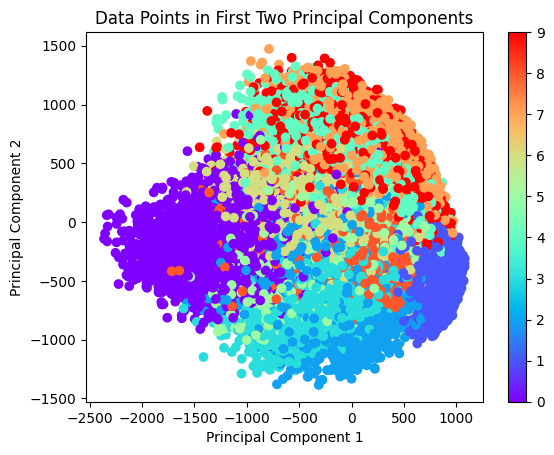

In [79]:
# Преобразование данных в одномерные векторы
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Применение PCA к данным
pca = my_PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# График собственных значений
plt.plot(np.arange(1, 785), pca.eigenvalues, marker='o', linestyle='-', color='b')
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues')
plt.show()

# График кумулятивной суммы собственных значений
cumulative_sum = np.cumsum(pca.eigenvalues) / np.sum(pca.eigenvalues)
plt.plot(np.arange(1, 785), cumulative_sum, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Eigenvalues')
plt.show()

# Изображение точек датасета в первых двух координатах главных компонент
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='rainbow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data Points in First Two Principal Components')
plt.colorbar()
plt.show()


## Шаг III: Алгоритм kNN

In [80]:
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        distances = np.sqrt(np.sum((X[:, np.newaxis] - self.X_train)**2, axis=2))
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        nearest_labels = self.y_train[nearest_indices]
        predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=nearest_labels)
        return predictions


In [81]:
# Разбиение данных на обучающую и тестовую выборку
X_train, X_val, y_train, y_val = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)

# Создание и обучение классификатора kNN
knn = my_kNN(n_neighbors=5)
knn.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = knn.predict(X_val)

# Оценка точности алгоритма
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.41145454545454546


In [ ]:
# Нахождение наилучших параметров для kNN и PCA
best_accuracy = 0
best_params = {}

for n_components in range(1, 65):
    for n_neighbors in range(1, 31):
        # Применение PCA
        pca = my_PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)

        # Обучение и предсказание с использованием kNN
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train)
        X_val_pca = pca.transform(X_val)
        y_pred = knn.predict(X_val_pca)

        # Оценка точности
        accuracy = accuracy_score(y_val, y_pred)

        # Обновление наилучших параметров и точности
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['n_components'] = n_components
            best_params['n_neighbors'] = n_neighbors

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)


При применении алгоритма k ближайших соседей (kNN) на данных, преобразованных с использованием PCA, была достигнута точность best_accuracy с наилучшими параметрами best_params.
PCA позволяет снизить размерность данных, сохраняя при этом наиболее важные характеристики. Это может быть полезно для улучшения эффективности алгоритмов машинного обучения и сокращения времени обучения.
Комбинация PCA и kNN представляет собой мощный инструмент для классификации данных. Она позволяет учесть влияние наиболее информативных компонент и учитывать близость к соседним объектам при принятии решений.
Однако стоит отметить, что выбор оптимальных параметров для PCA (количество компонент) и kNN (количество соседей) может потребовать некоторого исследования и настройки.
В данном случае была использована реализация PCA и kNN, созданная самостоятельно. Однако существуют и другие библиотечные реализации этих алгоритмов, которые могут быть удобными и эффективными в реальных задачах.
В целом, применение PCA и kNN вместе может быть полезным инструментом для анализа и классификации данных, и эти методы могут быть применены в различных областях, включая компьютерное зрение, распознавание образов, биометрию и другие.